# Ajuste de un histograma con verosimilitud

Espectro de rayos cósmicos de Auger

<ol>
<li>Todo el espectro</li>
<li>Baja energía (falla minimización 🡒 mal el error en b</li>
<li>Alta energía</li>
</ol>

In [1]:
%matplotlib notebook

In [2]:
import math
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import minimize

## Datos

Datos bineados en $x = log_{10}(E/eV)$, y = número de eventos en el bin

In [3]:
xdata = np.linspace(18.45, 20.45, 21)
ydata = np.array([13023, 7711, 4478, 3159, 2162, 1483, 1052, 699, 451, 323, 200, 110, 43, 28, 23, 5, 2, 0, 1, 0, 0])

Ajuste de todo el histograma

In [4]:
# xfit, yfit = xdata, ydata
# x0 = 19

*Nota: x0 es un valor de referencia de x para estabilizar el ajuste* 

Ajuste a *baja* energía

In [5]:
# xfit, yfit = xdata[3:11], ydata[3:11]
# x0 = 19

Ajuste a *alta* energía

In [6]:
xfit, yfit = xdata[10:], ydata[10:]
x0 = 19.5

In [7]:
print("xfit", xfit)
print("yfit", yfit)

xfit [19.45 19.55 19.65 19.75 19.85 19.95 20.05 20.15 20.25 20.35 20.45]
yfit [200 110  43  28  23   5   2   0   1   0   0]


In [8]:
nbins = len(xfit)
nbins

11

<IPython.core.display.Javascript object>


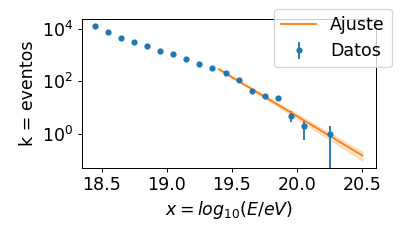

<ErrorbarContainer object of 3 artists>

In [9]:
fig1, ax1 = plt.subplots(figsize=(5,3))
ax1.set_xlabel('$x =log_{10}(E/eV)$')
ax1.set_ylabel('k = eventos')
ax1.set_yscale("log")
ysigma = np.sqrt(ydata)
ax1.errorbar(xdata, ydata, ysigma,ls='none', marker='o', ms=4, label='Datos')

## Modelo

In [10]:
def modelo(x, theta, x0):
    return np.power(10, theta[0]-theta[1]*(x-x0) ) 

## Función de costo

Costo de un solo bin

In [11]:
def bin_cost(mu, k):   
    if k==0:
        return 2*mu
    else:
        return 2*(mu-k)-2*k*np.log(mu/k)

Costo del ajuste

In [12]:
def funcion_costo(theta, xdata, ydata, x0):
        costo = np.zeros_like(theta[0])
        for (x1, y1) in zip(xdata, ydata):
            mu1 = modelo(x1, theta, x0)
            costo += bin_cost(mu1, y1)
        return costo

In [13]:
J = lambda theta: funcion_costo(theta, xfit, yfit, x0)  

## Minimización

Método BFGS (default)

In [14]:
res1 = minimize(J, x0=(2, 2))
res1

      fun: 14.04678706579353
 hess_inv: array([[0.00025904, 0.00059208],
       [0.00059208, 0.01188884]])
      jac: array([ 1.78813934e-06, -4.17232513e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([2.16161638, 2.97159986])

In [15]:
theta_est = res1.x
cova1 = 2 * res1.hess_inv
error = np.sqrt( np.diagonal(cova1) )
rho = cova1[0][1]/(error[0]*error[1])
print(f'a = {theta_est[0]:.3f} ± {error[0]:.3f}')
print(f'b = {theta_est[1]:.3f} ± {error[1]:.3f}')
print(f'ρ = {rho:.2f}')

a = 2.162 ± 0.023
b = 2.972 ± 0.154
ρ = 0.34


Método simplex

In [16]:
res2 = minimize(J, x0=(2, 2), method = 'Nelder-Mead')
res2

 final_simplex: (array([[2.16161347, 2.97157785],
       [2.16161323, 2.97163234],
       [2.16162411, 2.97164464]]), array([14.04678709, 14.04678716, 14.04678722]))
           fun: 14.046787093888762
       message: 'Optimization terminated successfully.'
          nfev: 75
           nit: 38
        status: 0
       success: True
             x: array([2.16161347, 2.97157785])

Hessian

In [17]:
def hessian_fun(theta, xdata, ydata, x0):
    
        h11, h12, h22 = 0, 0, 0
             
        for (x1, y1) in zip(xdata, ydata):
            mu1 = modelo(x1, theta, x0)
            h11 += mu1
            h12 += -(x1-x0) * mu1
            h22 += (x1-x0)**2 * mu1
            
        H = 2 * math.log(10)**2 * np.array([[h11, h12],[h12,h22]])    
            
        return  H

In [18]:
hessian = hessian_fun(res2.x, xfit, yfit, x0)

In [19]:
hessian

array([[4368.74608397, -223.74359358],
       [-223.74359358,   98.36673138]])

## Parámetros

In [20]:
theta_est = res2.x
cova2 = 2*inv(hessian)
error = np.sqrt( np.diagonal(cova2) )
rho = cova2[0][1]/(error[0]*error[1])
print(f'a = {theta_est[0]:.3f} ± {error[0]:.3f}')
print(f'b = {theta_est[1]:.3f} ± {error[1]:.3f}')
print(f'ρ = {rho:.2f}')

a = 2.162 ± 0.023
b = 2.972 ± 0.152
ρ = 0.34


## Bondad del ajuste

In [21]:
chi2_min = res2.fun
ndof = len(xfit) - len(theta_est)
pvalor = chi2.sf(chi2_min, ndof)
print(f'χ²min = {chi2_min:.1f}')
print(f'ndof = {ndof}')
print(f'pvalor = {pvalor*100:.2f}%')

χ²min = 14.0
ndof = 9
pvalor = 12.07%


## Errores gráficos

In [22]:
theta1 = np.linspace(theta_est[0]-4*error[0] , theta_est[0]+4*error[0], 100)
theta2 = np.linspace(theta_est[1]-4*error[1] , theta_est[1]+4*error[1], 100)
theta1, theta2 = np.meshgrid(theta1, theta2)
theta = np.array([theta1, theta2])
z = J(theta)

<IPython.core.display.Javascript object>


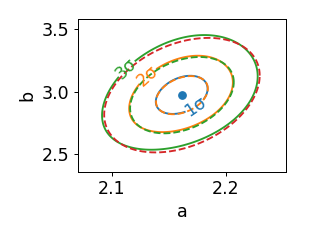

Text(0, 0.5, 'b')

In [23]:
fig2, ax2 = plt.subplots()
ax2.set_xlabel('a')
ax2.set_ylabel('b')

In [24]:
ax2.plot(*theta_est, 'o')

In [25]:
levels = chi2_min + np.array([1, 4, 9]) 

contour = ax2.contour(theta1, theta2, z, levels, colors=['tab:blue', 'tab:orange', 'tab:green'])

fmt = {}
strs = ['1σ', '2σ', '3σ']
for l, s in zip(contour.levels, strs):
    fmt[l] = s
ax2.clabel(contour, fmt=fmt)

<a list of 3 text.Text objects>

## Errores Hessiano

In [26]:
def get_ellipse(center, cova, nsigma=1):
    L = np.linalg.cholesky(cova)
    t = np.linspace(0, 2 * np.pi, 1000)
    circulo = np.column_stack([np.cos(t), np.sin(t)])
    elipse =  nsigma * circulo @ L.T + center
    return elipse.T

In [27]:
elipse_1sigma = get_ellipse(theta_est, cova2, nsigma=1)
ax2.plot(*elipse_1sigma, ls='--')
elipse_2sigma = get_ellipse(theta_est, cova2, nsigma=2)
ax2.plot(*elipse_2sigma, ls='--')
elipse_3sigma = get_ellipse(theta_est, cova2, nsigma=3)
ax2.plot(*elipse_3sigma, ls='--')

## Dibujar ajuste

In [28]:
x = np.linspace( xfit.min()-0.05, xfit.max()+0.05, 256)
mu_est = modelo(x, theta_est, x0)
ax1.plot(x, mu_est, label='Ajuste')
fig1.legend(fontsize='medium')

## Banda de error

In [29]:
grad_theta1 = math.log(10) * mu_est 
grad_theta2 = (x-x0) * math.log(10) * mu_est 
grad = np.column_stack( (grad_theta1, grad_theta2) )
var_mu_est = np.einsum("ki,ij,kj->k", grad, cova2, grad)
sigma_mu_est = np.sqrt(var_mu_est)
ax1.fill_between(x, mu_est-sigma_mu_est, mu_est+sigma_mu_est, color='tab:orange', alpha=0.2)

In [30]:
fig1.savefig('espectro_fit.svg')